In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# To have bigger plot sizes and use sns output in pandas plot-commands.
sns.set(rc={'figure.figsize': (9, 6)})

In [21]:
df = pd.read_csv('howpop_train.csv')
print(df.shape)
df.head(3)

(134137, 17)


,url,domain,post_id,published,author,flow,polling,content_len,title,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
0,https://habrahabr.ru/post/18284/,habrahabr.ru,18284,2008-01-01 18:19:00,@Tapac,develop,False,4305,Новогодний подарок блоггерам — WordPress 2.3.2,0,0,236,0.0,0.0,-0.792687,-1.344075,-2.436871
1,https://habrahabr.ru/post/18285/,habrahabr.ru,18285,2008-01-01 18:30:00,@DezmASter,design,False,7344,"Сумасшедшие яйца, или сервис для отслеживания ...",1,1,353,1.0,0.0,-0.485214,-0.831946,-1.873193
2,https://habrahabr.ru/post/18286/,habrahabr.ru,18286,2008-01-01 18:34:00,@DezmASter,design,False,8431,"Сумасшедшие яйца, или сервис для отслеживания ...",47,72,1200,45.0,5.0,0.446090,1.794023,0.574656


In [22]:
df.drop(list(df.filter(like='_lognorm')), axis='columns', inplace=True)

In [23]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
post_id,134137.0,181307.054265,81766.350702,18284.0,115565.0,182666.0,257401.0,314088.0
content_len,134137.0,7516.929699,8724.771640,1.0,2179.0,4949.0,9858.0,352471.0
comments,134137.0,39.625994,62.398958,0.0,7.0,19.0,48.0,2266.0
favs,134137.0,71.999866,145.854135,0.0,8.0,27.0,78.0,8718.0
views,134137.0,16631.013084,31479.819691,3.0,2100.0,7600.0,18700.0,1730000.0
votes_plus,133566.0,35.536888,42.461073,0.0,11.0,22.0,45.0,1466.0
votes_minus,133566.0,8.050035,11.398282,0.0,2.0,5.0,10.0,445.0


In [24]:
df.describe(include=['object', 'bool']).transpose()

,count,unique,top,freq
url,134137,134137,https://geektimes.ru/post/47669/,1
domain,134137,2,habrahabr.ru,97048
published,134137,130291,2011-06-14 15:52:00,39
author,97657,22077,@alizar,5292
flow,97048,6,develop,53318
polling,134137,2,False,129412
title,134137,133628,"Интересные события, произошедшие в выходные",56


In [25]:
print(df['published'].dtype)
df['published'] = pd.to_datetime(df['published'], yearfirst=True)
print(df['published'].dtype)

object
datetime64[ns]


In [27]:
# January=1, December=12, Monday=0, Sunday=6
df = df.assign(year=df['published'].dt.year,
               month=df['published'].dt.month,
               dayofweek=df['published'].dt.dayofweek,
               dayname=df['published'].dt.day_name(),
               hour=df['published'].dt.hour)
df.head(3)

,url,domain,post_id,published,author,flow,polling,content_len,title,comments,favs,views,votes_plus,votes_minus,year,month,dayofweek,dayname,hour
0,https://habrahabr.ru/post/18284/,habrahabr.ru,18284,2008-01-01 18:19:00,@Tapac,develop,False,4305,Новогодний подарок блоггерам — WordPress 2.3.2,0,0,236,0.0,0.0,2008,1,1,Tuesday,18
1,https://habrahabr.ru/post/18285/,habrahabr.ru,18285,2008-01-01 18:30:00,@DezmASter,design,False,7344,"Сумасшедшие яйца, или сервис для отслеживания ...",1,1,353,1.0,0.0,2008,1,1,Tuesday,18
2,https://habrahabr.ru/post/18286/,habrahabr.ru,18286,2008-01-01 18:34:00,@DezmASter,design,False,8431,"Сумасшедшие яйца, или сервис для отслеживания ...",47,72,1200,45.0,5.0,2008,1,1,Tuesday,18


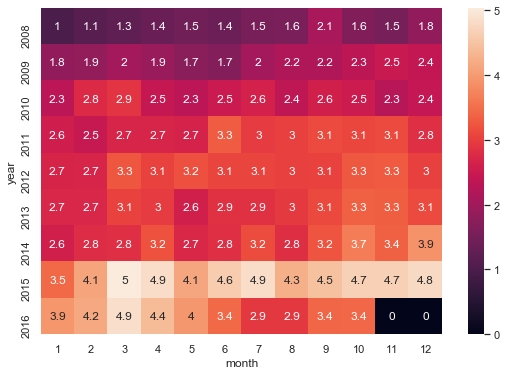

In [108]:
year_month_papers = df.pivot_table(index='year', columns='month',
                                   values='post_id', aggfunc='count').fillna(0)
min_papers = year_month_papers.where(year_month_papers > 0).min().min()

sns.heatmap(year_month_papers / min_papers, annot=True)

Let's look closer at papers in March 2016.

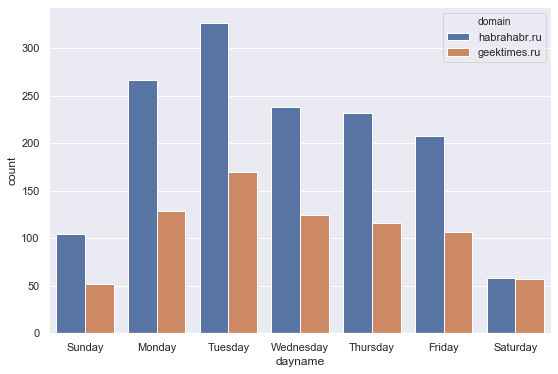

In [109]:
papers_march_2015 = df[(df['year']==2015) & (df['month']==3)]
sns.countplot(x='dayname', hue='domain', data=papers_march_2015)

Text(0.5, 1.0, 'Views')

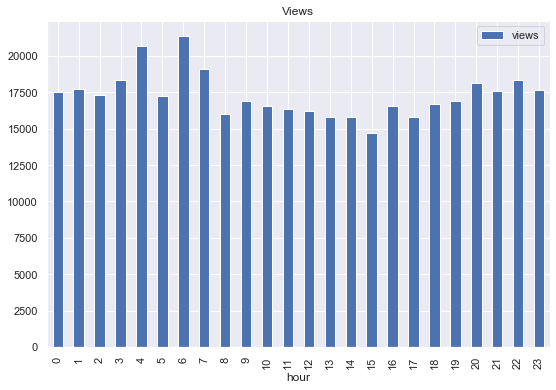

In [110]:
df.groupby('hour')[['views']].mean().plot(kind='bar')
plt.title('Views')

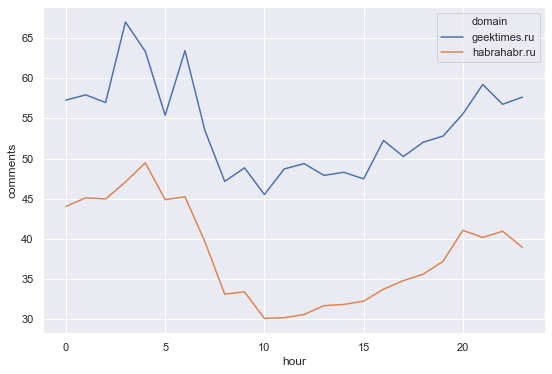

In [129]:
comments = df.groupby(['hour', 'domain']).agg(comments=('comments', 'mean')).reset_index()
sns.lineplot(x='hour', y='comments', hue='domain', data=comments)

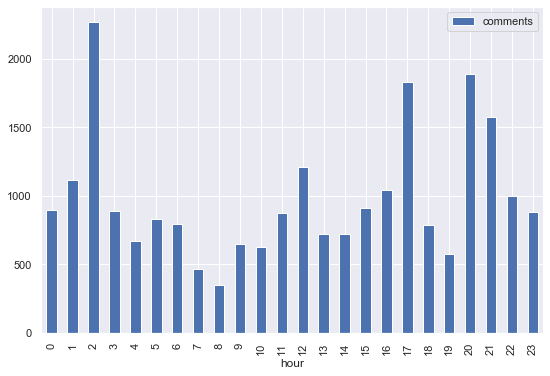

In [84]:
df[df['domain']=='geektimes.ru'].groupby('hour') \
                                .agg(comments=('comments', 'max')).plot(kind='bar')

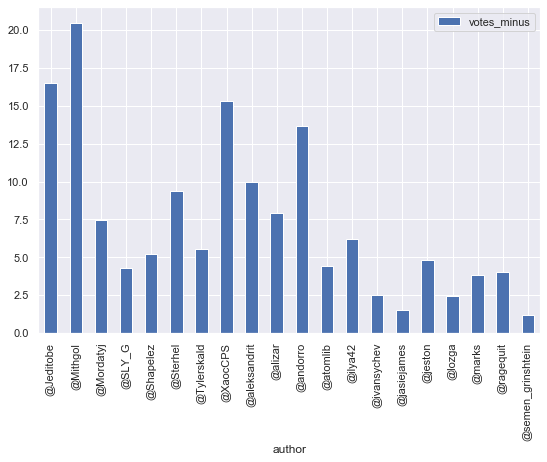

In [128]:
top20_authors = df.groupby('author').count().nlargest(20, 'title').index

df[df['author'].isin(top20_authors)].groupby('author') \
                                    .agg(votes_minus=('votes_minus', 'mean')) \
                                    .plot(kind='bar')

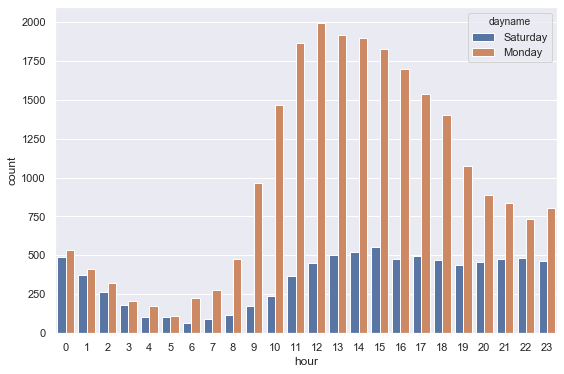

In [100]:
sns.countplot(x='hour', hue='dayname', data=df[df['dayname'].isin(['Monday', 'Saturday'])])